# Compare calculated bioclimatic variables (ERA5) to Bioclim

Selected variables:
> BIO1  = Annual Mean Temperature\
> BIO4  = Temperature Seasonality (standard deviation ×100)\
> BIO5  = Max Temperature of Warmest Month\
> BIO6  = Min Temperature of Coldest Month\
> BIO12 = Annual Precipitation \
> BIO15 = Precipitation Seasonality (Coefficient of Variation)\
> BIO16 = Precipitation of Wettest Quarter\
> BIO17 = Precipitation of Driest Quarter\
> BIO18 = Precipitation of Warmest Quarter

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.features import rasterize
from datetime import date, timedelta
import glob

# plotting
import matplotlib.pyplot as plt
import contextily as ctx

In [3]:
# load calculated bioclimatic variables (from era5)
bio = xr.open_dataset('../ClimateVariablesOut/bioclimatic_variables_30km.nc')

# take 1970 - 2000 average
bio_mean = bio.sel(year = slice(1970, 2000)).mean(dim='year')

# write crs EPSG:4326
for var in bio_mean.data_vars:
    bio_mean[var] = bio_mean[var].rio.write_crs('EPSG:4326', inplace=True)

# rename variables
varnames = ['bio1', 'bio4', 'bio5', 'bio6', 'bio12', 'bio15', 'bio16', 'bio17', 'bio18']
bio_mean = bio_mean.rename({var: varnames[i] for i, var in enumerate(bio_mean.data_vars)})

In [4]:
# load worldclim bioclimatic variables
bio1_wc = xr.open_dataset('../../Data/ClimateVariables/Worldclim5m/wc2.1_5m_bio_1.tif')
bio4_wc = xr.open_dataset('../../Data/ClimateVariables/Worldclim5m/wc2.1_5m_bio_4.tif')
bio5_wc = xr.open_dataset('../../Data/ClimateVariables/Worldclim5m/wc2.1_5m_bio_5.tif')
bio6_wc = xr.open_dataset('../../Data/ClimateVariables/Worldclim5m/wc2.1_5m_bio_6.tif')
bio12_wc = xr.open_dataset('../../Data/ClimateVariables/Worldclim5m/wc2.1_5m_bio_12.tif')
bio15_wc = xr.open_dataset('../../Data/ClimateVariables/Worldclim5m/wc2.1_5m_bio_15.tif')
bio16_wc = xr.open_dataset('../../Data/ClimateVariables/Worldclim5m/wc2.1_5m_bio_16.tif')
bio17_wc = xr.open_dataset('../../Data/ClimateVariables/Worldclim5m/wc2.1_5m_bio_17.tif')
bio18_wc = xr.open_dataset('../../Data/ClimateVariables/Worldclim5m/wc2.1_5m_bio_18.tif')

bio_cw_dict = {
    'bio1': bio1_wc.rio.reproject_match(bio_mean['bio1'])['band_data'],
    'bio4': bio4_wc.rio.reproject_match(bio_mean['bio4'])['band_data'],
    'bio5': bio5_wc.rio.reproject_match(bio_mean['bio5'])['band_data'],
    'bio6': bio6_wc.rio.reproject_match(bio_mean['bio6'])['band_data'],
    'bio12': bio12_wc.rio.reproject_match(bio_mean['bio12'])['band_data'],
    'bio15': bio15_wc.rio.reproject_match(bio_mean['bio15'])['band_data'],
    'bio16': bio16_wc.rio.reproject_match(bio_mean['bio16'])['band_data'],
    'bio17': bio17_wc.rio.reproject_match(bio_mean['bio17'])['band_data'],
    'bio18': bio18_wc.rio.reproject_match(bio_mean['bio18'])['band_data']
}

bio_wc = xr.Dataset(bio_cw_dict)

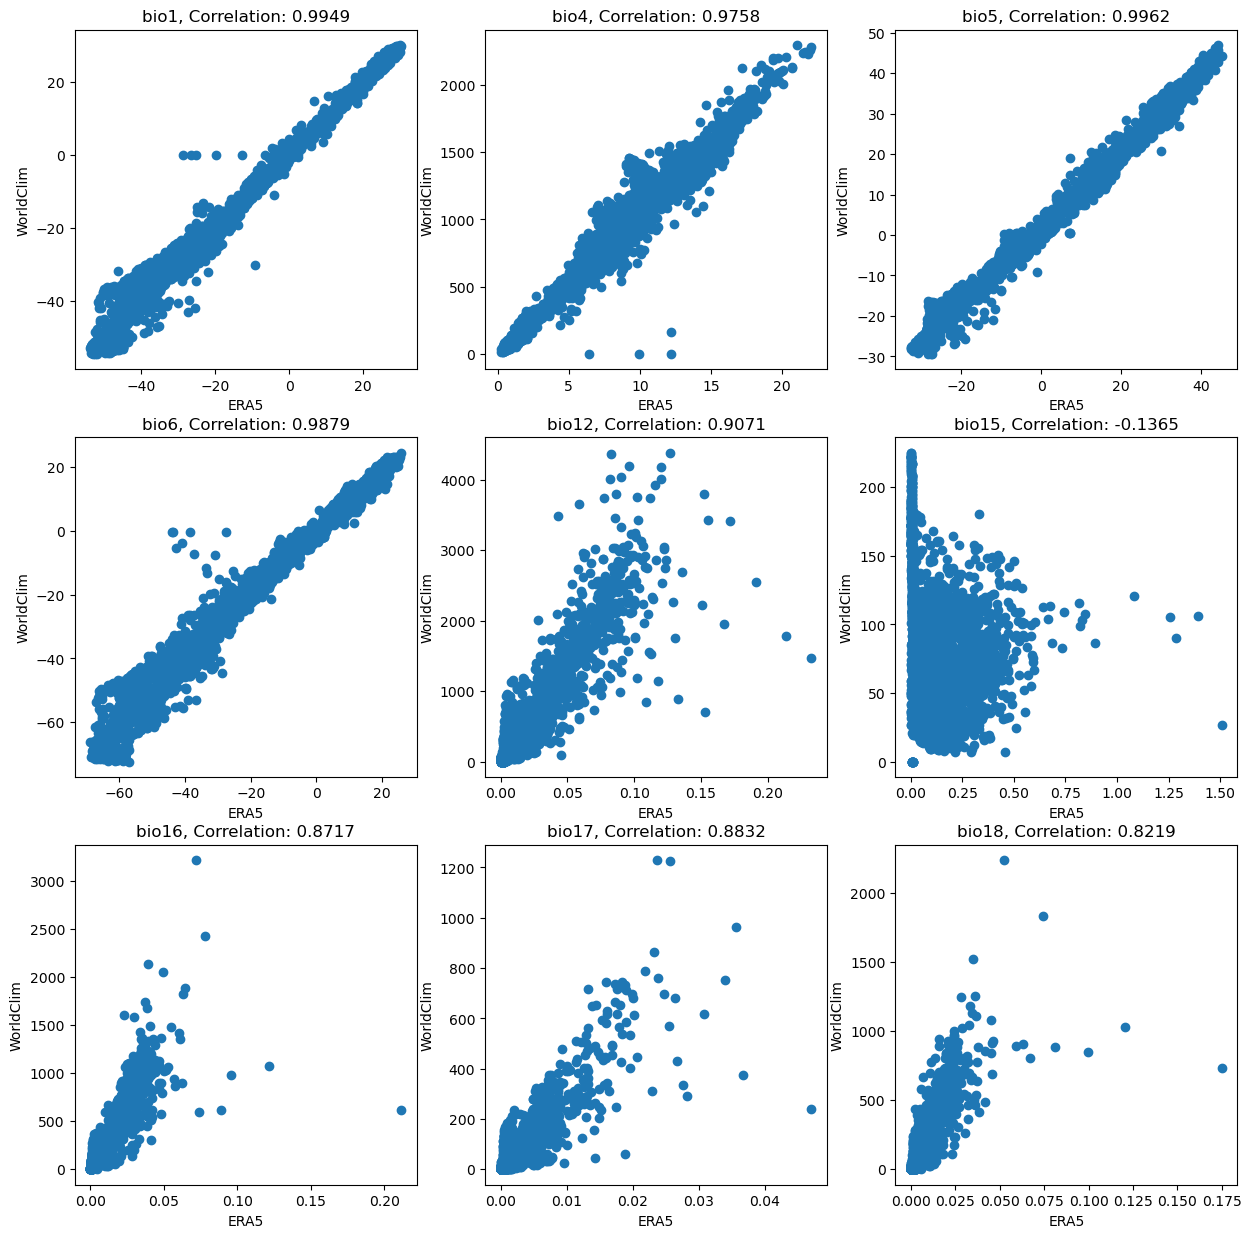

In [6]:
# test corellations for downscaled bioclimatic variables (e.g. 2°)
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, var in enumerate(bio_wc.data_vars):
    wc1_flat = bio_wc[var].values[0].flatten()
    x = bio_mean[var].values.flatten()[~np.isnan(wc1_flat)] 
    y = wc1_flat[~np.isnan(wc1_flat)]
    # randomly subsample 10% for plotting
    idx = np.random.choice(len(x), int(len(x) * 0.01), replace=False)
    x = x[idx]
    y = y[idx]
    ax[int(i/3), i%3].plot(x, y, 'o')
    ax[int(i/3), i%3].set_xlabel('ERA5')
    ax[int(i/3), i%3].set_ylabel('WorldClim')
    ax[int(i/3), i%3].set_title(var + ', Correlation: ' + str(np.round(np.corrcoef(x, y)[0, 1], 4)))

Even if Bio15, Precipitation seasonality does not seem to match with the Worldclim data, it is consistently calculated, following O'Donnel et al. 2012 so I will continue to use it.

Text(0.5, 1.0, 'bio15, Correlation: 0.259')

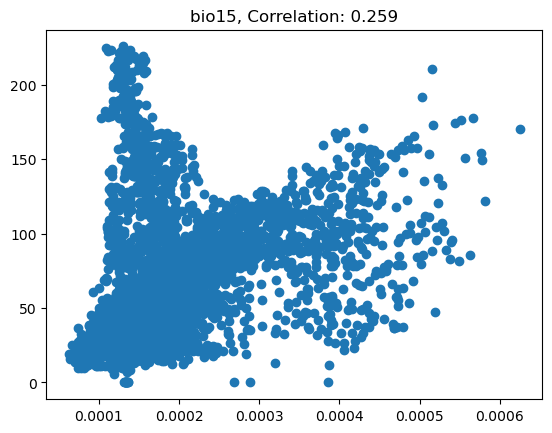

In [5]:
# Focussin on Bio15
# load bio15 with only std
bio15 = xr.open_dataset('../ClimateVariablesOut/bioclimatic_variables_Bio15_30km_2.nc')

# take 1970 - 2000 average
bio15_mean = bio15.sel(year = slice(1970, 2000)).mean(dim='year')

# plot variables
var = 'bio15'
wc1_flat = bio_wc[var].values[0].flatten()
x = bio15_mean.tp.values.flatten()[~np.isnan(wc1_flat)] 
y = wc1_flat[~np.isnan(wc1_flat)]
# randomly subsample 10% for plotting
idx = np.random.choice(len(x), int(len(x) * 0.01), replace=False)
x = x[idx]
y = y[idx]
plt.scatter(x, y)
plt.title(var + ', Correlation: ' + str(np.round(np.corrcoef(x, y)[0, 1], 4)))

Text(0.5, 1.0, 'Heidelberg ERA5 regional download converted from grib')

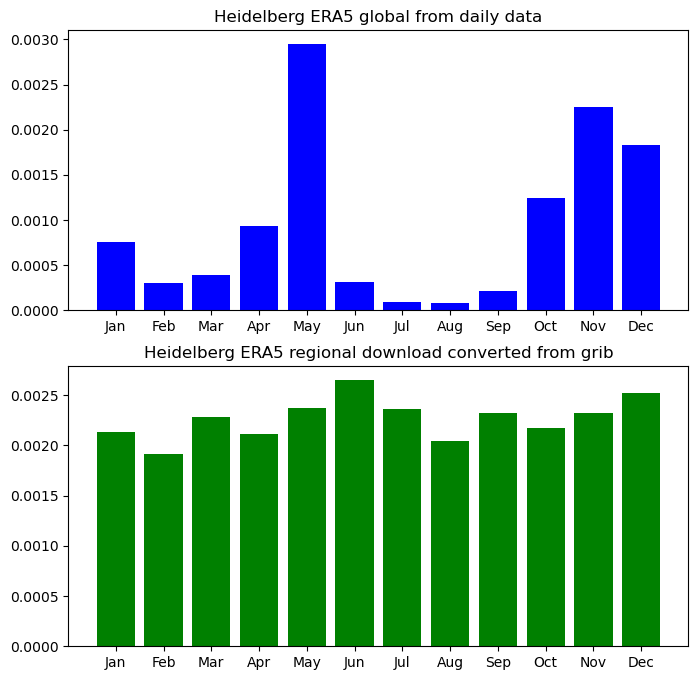

In [4]:
# load era5 precipitation data
P_calc = xr.open_dataset('../../Data/ClimateVariables/ERA5_prec_1940_2023.nc')
ds = xr.open_dataset('../../Data/ClimateVariables/ERA5_monthly/ERA5_evap_test.nc')
P_part = ds.tp_0001

# calculate monthly precipitation means for 1970 - 2000 in Heidelberg (~ 51°N, 7°E)
hd_calc = P_calc.sel(longitude=51,latitude=7,method='nearest').sel(time=slice('1970-01-01', '1999-12-31')).tp[:,0]
phd_part = P_part.sel(longitude=51,latitude=7,method='nearest').sel(time=slice('1970-01-01', '1999-12-31'))

hd_calc = hd_calc.groupby('time.month').mean(dim='time')
phd_part = phd_part.groupby('time.month').mean(dim='time')

# plot the three bar charts
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax[0].bar(months, hd_calc.values, color='b')
ax[0].set_title('Heidelberg ERA5 global from daily data')
ax[1].bar(months, phd_part.values, color='g')
ax[1].set_title('Heidelberg ERA5 regional download converted from grib')

In [27]:
P_full.sel(longitude=51,latitude=7, expver=5, method='nearest').sel(time=slice('1970-01-01', '1999-12-31'))

<xarray.Dataset> Size: 6kB
Dimensions:    (time: 360)
Coordinates:
    longitude  float32 4B 51.0
    latitude   float32 4B 7.0
    expver     int32 4B 5
  * time       (time) datetime64[ns] 3kB 1970-01-01 1970-02-01 ... 1999-12-01
Data variables:
    tp         (time) float64 3kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-03 09:47:55 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [17]:
phd_full

<xarray.DataArray 'tp' (month: 12)> Size: 96B
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    longitude  float32 4B 51.0
    latitude   float32 4B 7.0
    expver     int32 4B 1
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      m
    long_name:  Total precipitation

345.4394770558495

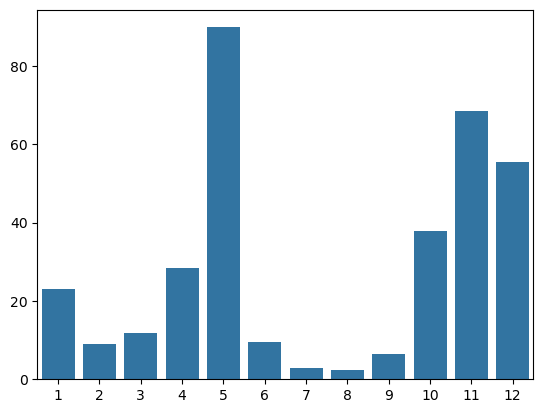

In [87]:
# slice out 1970 - 2000 in heidelberg
hd_lon = 49.45
hd_lat = 8.40

p_hd_era5 = P.sel(longitude=51,latitude=7,method='nearest').sel(time=slice('1970-01-01', '1999-12-31')).tp[:,0]


# print bar diagram of average precipitation in each month
bars = p_hd_era5.groupby('time.month').mean().values * 365.25/12 * 1000
import seaborn as sns
sns.barplot(x=np.arange(1, 13), y=bars)
# plt.plot(p_hd_era5)


# temporal mean
# mean = P.mean(dim='time')
# mean
bars.sum() 

In [61]:
P

<xarray.DataArray 'tp_0001' (time: 360)> Size: 3kB
array([0.002147, 0.004422, 0.002699, ..., 0.001701, 0.00196 , 0.003898])
Coordinates:
    longitude  float32 4B 7.5
    latitude   float32 4B 50.5
  * time       (time) datetime64[ns] 3kB 1970-01-01 1970-02-01 ... 1999-12-01
Attributes:
    units:      m
    long_name:  Total precipitation

In [3]:
# calculate Bio15 from worldclim data

# load monthly precipitation data from worldclim
files = np.sort(glob.glob('../../Data/ClimateVariables/Worldclim10m_monthly/*'))

# load all tif files in ´files´ into a xarray dataset. 
# The files are loaded into a list of xarray datasets and then merged into a single dataset.
# Each file represents a new time in the same grid. 
# The month is stored in yyyy-mm format in file.split('_')[4].split('.')[0]
for i, file in enumerate(files):
    year = int(file.split('_')[4].split('.')[0].split('-')[0])
    month = int(file.split('_')[4].split('.')[0].split('-')[1])
    
    if i == 0:
        p_wc = xr.open_dataarray(file)
        p_wc = p_wc.rename({'band': 'time'})
        p_wc['time'] = [date(year, month, 1)]
    else:
        p_wc_tmp = xr.open_dataarray(file)
        p_wc_tmp = p_wc_tmp.rename({'band': 'time'})
        p_wc_tmp['time'] = [date(year, month, 1)]
        p_wc = xr.concat([p_wc, p_wc_tmp], dim='time')
    

In [22]:
hd_wc = p_wc.sel(x=49.40,y=8.70,method='nearest')
# filter out data in december
# hd = hd.sel(time=hd['time.month'] == 12)

# open era5 total precipitation

AttributeError: 'IndexVariable' object has no attribute 'dt.month'

In [91]:
p_wc.attrs['units'] = 'mm'


p_wc['time'] = pd.to_datetime(p_wc['time'])

# calculate yearly sum years are in "time" dim in datetime.date format
p_wc_yearly = p_wc.resample(time='YE').sum()
p_wc_yearlyb15 = p_wc.resample(time='YE').std() / ( 1 + p_wc_yearly/12) * 100

In [115]:
# take means over time
bio12_wc = p_wc_yearly.mean(dim='time')
bio15_wc = p_wc_yearlyb15.mean(dim='time')

# flip y axis
bio12_wc = bio12_wc.reindex(y=bio12_wc.y[::-1])
bio15_wc = bio15_wc.reindex(y=bio15_wc.y[::-1])

# # resmple
bio12_wc = bio12_wc.rio.reproject_match(bio_mean['bio12'])
bio15_wc = bio15_wc.rio.reproject_match(bio_mean['bio15'])

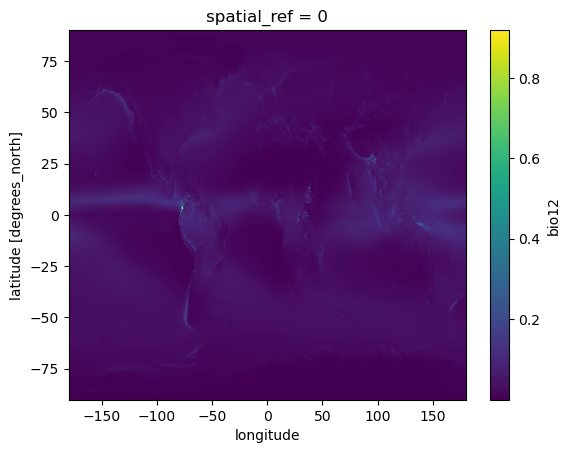

In [118]:
# plot, max = 7000
# bio12_wc.plot(vmax=7000)
bio_mean['bio12'].plot()

Text(0.5, 1.0, 'Difference between ERA5 and WorldClim, bio1')

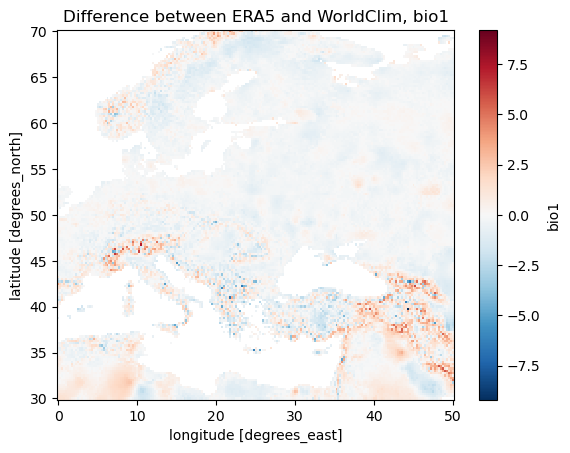

In [12]:
var = 'bio1'
d = (bio_wc[var].squeeze('band').rename({'y': 'latitude', 'x': 'longitude'}) - bio_mean[var])
d.sel(latitude=slice(30, 70), longitude=slice(0, 50)).plot()
plt.title('Difference between ERA5 and WorldClim, ' + var)

In [129]:
bio_mean['bio1'].values.flatten()[~np.isnan(wc1_flat)]

array([-45.963737, -45.961983, -45.96022 , ..., -15.092045, -14.626665,
       -14.169086], dtype=float32)